In [ ]:
# 한글 깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 0s (24.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 122349 files and dir

In [1]:
from google.colab import drive
drive.mount('/content/mnt')

Mounted at /content/mnt


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from datetime import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt

sns.set_palette("bright")
sns.set_style('darkgrid')

# 데이터 불러오기

In [3]:
import pickle

def load_file(name):
    with open(f'/content/mnt/MyDrive/LDA/data/{name}.pk', 'rb') as fr:
        data = pickle.load(fr)
    return data

In [4]:
interaction = pd.read_csv("/content/mnt/MyDrive/LDA/data/interaction.csv")
interaction.drop(columns = ["vst_dt"], axis = 1, inplace = True)

valid_true_label = load_file("valid_true_label")
valid_user_list = load_file("valid_user_list")
valid_pred_list = load_file("valid_pred_list")

valid_true_label_wo_price = load_file("valid_true_label_wo_price")
valid_user_list_wo_price = load_file("valid_user_list_wo_price")
valid_pred_list_wo_price = load_file("valid_pred_list_wo_price")

test_true_label = load_file("test_true_label")
test_user_list = load_file("test_user_list")
test_pred_list = load_file("test_pred_list")

user_emb = pd.read_csv("/content/mnt/MyDrive/LDA/data/user_emb.csv")
item_emb = pd.read_csv("/content/mnt/MyDrive/LDA/data/item_emb.csv")

user_emb_wo = pd.read_csv("/content/mnt/MyDrive/LDA/data/user_emb_wo_price.csv")
item_emb_wo = pd.read_csv("/content/mnt/MyDrive/LDA/data/item_emb_wo_price.csv")

<ipython-input-4-95b4b78050cb>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interaction = pd.read_csv("/content/mnt/MyDrive/LDA/data/interaction.csv")


In [5]:
valid_user_pred = dict(zip(valid_user_list, valid_pred_list))
test_user_pred = dict(zip(test_user_list, test_pred_list))

valid_user_pred_wo_price = dict(zip(valid_user_list_wo_price, valid_pred_list_wo_price))

In [6]:
demo = pd.read_csv("/content/mnt/MyDrive/LDA/data/LPOINT_BIG_COMP_01_DEMO.csv")

# Q1. Test 데이터셋에서 정확도 성능이 더 잘나온 이유는?
  - Valid 데이터셋에 대한 추천엔 Cold-Start 유저도 포함되기 때문이다.
    - 제외 시 Valid 데이터셋에서 더 높은 성능이 나온다.

- `가격 정보` 포함한 경우
  - Valid
    - nDCG@5 : 0.713
    - hit rate@5 : 0.769
  - Test
    - nDCG@5 : 0.727
    - hit rate@5 : 0.772
  - `Cold-Start User` 제외 시
    - Valid
      - nDCG@5 : 0.7410
      - hit rate@5 : 0.7924
    
- `가격 정보` 포함하지 않은 경우
  - Valid
    - nDCG@5 : 0.653
    - hit rate@5 : 0.759
  - Test
    - nDCG@5 : 0.678
    - hit rate@5 : 0.764

In [ ]:
cold_user = set(valid_user_pred.keys()) - set(test_user_pred.keys())
print(f"Cold-Start 유저 수 : {len(cold_user)}")

Cold-Start 유저 수 : 1474


In [ ]:
import numpy as np

def get_hr(gt_item, pred_items):
    """
    HitRate
    """
    if gt_item in pred_items:
        return 1
    return 0

def get_ndcg(gt_item, pred_items):
    """
    nDCG
    """
    if gt_item in pred_items:
        index = pred_items.index(gt_item)
        return np.reciprocal(np.log2(index+2))
    return 0

def get_metrics(user_pred, label_list, k):
  HR, nDCG = [], []
  for uid, pred in user_pred.items():
    label = label_list[uid][0]
    HR.append(get_hr(label, pred[:k]))
    nDCG.append(get_ndcg(label ,pred[:k]))

  print(f"nDCG@{k}:", np.mean(nDCG))  
  print(f"hit rate@{k}:", np.mean(HR))

### 1) Cold-Start 유저에 대한 예측 정확도

In [ ]:
cold_user_pred = {uid : pred for uid,pred in valid_user_pred.items() if uid in cold_user}
cold_label = {uid : pred for uid,pred in valid_true_label.items() if uid in cold_user}

get_metrics(cold_user_pred, cold_label, 5)

nDCG@5: 0.3057073397404277
hit rate@5: 0.45725915875169604


##2) Cold-Start 유저를 제외한 Valid 추천 정확도 → Test 보다 높은 성능 기록

In [ ]:
wo_cold_user_pred = {uid : pred for uid,pred in valid_user_pred.items() if uid not in cold_user}
wo_cold_label = {uid : pred for uid,pred in valid_true_label.items() if uid not in cold_user}

get_metrics(wo_cold_user_pred, wo_cold_label, 5)

nDCG@5: 0.7409843229366168
hit rate@5: 0.792446762898385


# Q2. 추천이 어떤 방식으로 이뤄지고 있는지

## Cold-Start 유저에 대한 추천이 효과적인지
- 인기도 기반 추천과 비교 했을 때, 더 좋은 성능이 나오는지 확인

### 인기도 기반 추천 진행
- 유저 Demo 정보를 기준으로 인기도 상위 제품 추천

In [ ]:
demo_active = demo.loc[demo.cust.isin(sorted(set(interaction.cust)))].reset_index()
demo_active['uid'] = demo_active.index
demo_active['demo'] = demo_active["ma_fem_dv"] + demo_active['ages'] + demo_active['zon_hlv']
demo_active

,index,cust,ma_fem_dv,ages,zon_hlv,uid,demo
0,0,M000034966,여성,40대,Z07,0,여성40대Z07
1,1,M000059535,여성,30대,Z12,1,여성30대Z12
2,2,M000136117,여성,30대,Z11,2,여성30대Z11
3,3,M000201112,여성,50대,Z17,3,여성50대Z17
4,4,M000225114,여성,40대,Z17,4,여성40대Z17
...,...,...,...,...,...,...,...
29869,29908,M999708287,여성,40대,Z10,29869,여성40대Z10
29870,29909,M999770689,여성,30대,Z16,29870,여성30대Z16
29871,29910,M999849895,여성,20대,Z04,29871,여성20대Z04
29872,29911,M999926092,남성,30대,Z08,29872,남성30대Z08


- Cold-start 유저 정보

In [ ]:
cold_user_info = demo_active.loc[demo_active.uid.isin(cold_user)]
cold_user_info

,index,cust,ma_fem_dv,ages,zon_hlv,uid,demo
1,1,M000059535,여성,30대,Z12,1,여성30대Z12
13,13,M000608261,남성,30대,Z17,13,남성30대Z17
17,17,M000713279,여성,50대,Z12,17,여성50대Z12
19,19,M000859319,남성,70대,Z17,19,남성70대Z17
24,24,M001086020,남성,50대,Z17,24,남성50대Z17
...,...,...,...,...,...,...,...
29721,29760,M994285756,남성,60대,Z10,29721,남성60대Z10
29727,29766,M994550219,여성,20대,Z04,29727,여성20대Z04
29766,29805,M996060733,여성,30대,Z03,29766,여성30대Z03
29808,29847,M997346183,여성,30대,Z10,29808,여성30대Z10


- 학습 데이터 기간 동안의 (`20211115`) 거래 데이터를 통해 인기 상품 확인  

In [ ]:
temp = interaction.loc[interaction.de_dt < 20211115]
temp['demo'] = temp["ma_fem_dv"] + temp['ages'] + temp['zon_hlv']
temp.head(5)

<ipython-input-26-b875b55929e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['demo'] = temp["ma_fem_dv"] + temp['ages'] + temp['zon_hlv']


,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,deal_type,ma_fem_dv,ages,zon_hlv_user,zon_hlv,zon_mcls,pd_nm,clac_mcls_nm,clac_hlv_nm,demo
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1.0,0,여성,50대,Z17,Z10,Z10042,남성티셔츠,남성의류상의,남성의류,여성50대Z10
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1.0,0,여성,40대,Z13,Z13,Z13001,기타주방일회용품,주방일회용품,주방잡화,여성40대Z13
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,0,여성,50대,Z17,Z10,Z10042,남성티셔츠,남성의류상의,남성의류,여성50대Z10
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,0,여성,50대,Z17,Z10,Z10042,남성티셔츠,남성의류상의,남성의류,여성50대Z10
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,0,여성,50대,Z17,Z10,Z10042,남성티셔츠,남성의류상의,남성의류,여성50대Z10


- 활용 가능한 `Demo` 정보를 통해 인기 상품 추출

In [ ]:
popular_by_demo = temp.groupby("demo")['pd_c'].value_counts()
popular_by_demo

demo      pd_c  
남성20대Z01  PD1937    158
          PD1183     57
          PD1330     36
          PD0282     32
          PD0232     31
                   ... 
여성70대Z19  PD1937      5
          PD1944      4
          PD1940      2
          PD1945      2
          PD1946      2
Name: pd_c, Length: 142301, dtype: int64

In [ ]:
popular_by_demo = list(popular_by_demo.index)

top5_by_demo = {}

for demo_info, pd in popular_by_demo:
  if demo_info not in top5_by_demo:
    top5_by_demo[demo_info] = []
  if len(top5_by_demo[demo_info]) < 5:
    top5_by_demo[demo_info].append(int(pd[2:])- 1)

top5_by_demo

{'남성20대Z01': [1936, 1182, 1329, 281, 231],
 '남성20대Z02': [1172, 1177, 281, 327, 334],
 '남성20대Z03': [1936, 1483, 1937, 479, 401],
 '남성20대Z04': [1936, 1483, 479, 1416, 1332],
 '남성20대Z05': [1936, 231, 217, 1172, 379],
 '남성20대Z06': [1936, 479, 1684, 528, 231],
 '남성20대Z07': [1937, 1936, 1329, 1330, 1938],
 '남성20대Z08': [1936, 379, 231, 1483, 1183],
 '남성20대Z09': [1936, 1483, 1689, 1164, 380],
 '남성20대Z10': [1936, 287, 1483, 1934, 379],
 '남성20대Z11': [1483, 1180, 479, 1936, 231],
 '남성20대Z12': [1936, 380, 1937, 379, 1332],
 '남성20대Z13': [1936, 1330, 1182, 1151, 380],
 '남성20대Z14': [1936, 380, 281, 412, 1183],
 '남성20대Z15': [1936, 1937, 1689, 1242, 1329],
 '남성20대Z16': [380, 1936, 1332, 379, 231],
 '남성20대Z17': [1938, 1936, 1935, 1937, 1483],
 '남성20대Z18': [1934, 1940, 1946, 1939, 1936],
 '남성20대Z19': [1944, 1941, 1942, 1936, 1943],
 '남성30대Z01': [1936, 1933, 1416, 1483, 1332],
 '남성30대Z02': [383, 1177, 380, 528, 358],
 '남성30대Z03': [380, 1936, 1183, 1483, 1182],
 '남성30대Z04': [1936, 1483, 479, 231, 412],
 '남

- 인기도 기반 추천

In [ ]:
cold_user_info['pred'] = cold_user_info['demo'].apply(lambda x : top5_by_demo[x])
cold_user_info

<ipython-input-29-fd92432b62e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cold_user_info['pred'] = cold_user_info['demo'].apply(lambda x : top5_by_demo[x])


,index,cust,ma_fem_dv,ages,zon_hlv,uid,demo,pred
1,1,M000059535,여성,30대,Z12,1,여성30대Z12,"[1936, 1483, 231, 1937, 1329]"
13,13,M000608261,남성,30대,Z17,13,남성30대Z17,"[1936, 1935, 1483, 231, 1937]"
17,17,M000713279,여성,50대,Z12,17,여성50대Z12,"[1936, 1483, 231, 1155, 1485]"
19,19,M000859319,남성,70대,Z17,19,남성70대Z17,"[1155, 217, 1485, 1386, 196]"
24,24,M001086020,남성,50대,Z17,24,남성50대Z17,"[231, 1155, 1483, 1329, 1936]"
...,...,...,...,...,...,...,...,...
29721,29760,M994285756,남성,60대,Z10,29721,남성60대Z10,"[1483, 1155, 1151, 1386, 402]"
29727,29766,M994550219,여성,20대,Z04,29727,여성20대Z04,"[1936, 479, 1483, 1416, 1172]"
29766,29805,M996060733,여성,30대,Z03,29766,여성30대Z03,"[1936, 231, 479, 401, 1689]"
29808,29847,M997346183,여성,30대,Z10,29808,여성30대Z10,"[1936, 287, 1483, 231, 479]"


### 인기도 기반 추천 성능 확인
- nDCG@5 : 0.1346
- HR@5 : 0.1818

In [ ]:
cold_user_pred = {uid : list(cold_user_info.loc[cold_user_info.uid == uid].pred.values)[0] for uid, _ in valid_user_pred.items() if uid in cold_user}
cold_label = {uid : pred for uid,pred in valid_true_label.items() if uid in cold_user}

get_metrics(cold_user_pred, cold_label, 5)

nDCG@5: 0.13466858411326743
hit rate@5: 0.18181818181818182


### 모델 추천 성능 확인
- 단순 인기도 기반 보다 `모델에 의한 추천`이 `더 높은 성능`을 기록

In [ ]:
cold_user_pred = {uid : pred for uid,pred in valid_user_pred.items() if uid in cold_user}
cold_label = {uid : pred for uid,pred in valid_true_label.items() if uid in cold_user}

get_metrics(cold_user_pred, cold_label, 5)

nDCG@5: 0.3057073397404277
hit rate@5: 0.45725915875169604


# Q3. 유저 임베딩 양상 확인

## Rapids 설치
- `sklearn`에 `GPU`를 사용할 수 있음

In [ ]:
import pynvml

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
device_name = pynvml.nvmlDeviceGetName(handle)

if (device_name != b'Tesla T4') and (device_name != b'Tesla P4') and (device_name != b'Tesla P100-PCIE-16GB'):
  raise Exception("""
    Unfortunately this instance does not have a T4, P4 or P100 GPU.
    
    Please make sure you've configured Colab to request a GPU instance type.
    
    Sometimes Colab allocates a Tesla K80 instead of a T4, P4 or P100. Resetting the instance.
If you get a K80 GPU, try Runtime -> Reset all runtimes...
  """)
else:
  print('Woo! You got the right kind of GPU!')

Woo! You got the right kind of GPU!


In [ ]:
!pip install cudf-cu11 dask-cudf-cu11 --extra-index-url=https://pypi.nvidia.com
!pip install cuml-cu11 --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.nvidia.com
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.nvidia.com


In [ ]:
from cuml import KMeans, DBSCAN, TSNE, PCA
from cuml.preprocessing import Normalizer, StandardScaler

import cudf
import cupy

import pandas as pd

## 가격 정보 O 임베딩

In [ ]:
user_emb_cudf = cudf.DataFrame(user_emb)
tsne = TSNE(n_components = 2).fit_transform(user_emb_cudf.drop(columns = ["Unnamed: 0", "cust"]))

/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [05:40:01.847140] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


In [ ]:
tsne_df = tsne.to_pandas()
tsne_df.columns = ["x", "y"]
tsne_df

,x,y
0,-41.500454,2.296014
1,-40.516258,8.799566
2,-1.166095,52.087975
3,25.280260,28.364918
4,-26.766010,40.854664
...,...,...
29869,-40.679958,-46.494701
29870,36.540230,-19.832880
29871,-15.554584,-29.544323
29872,10.726204,-37.977596


### t-SNE Plot 결과 확인

<Axes: xlabel='x', ylabel='y'>

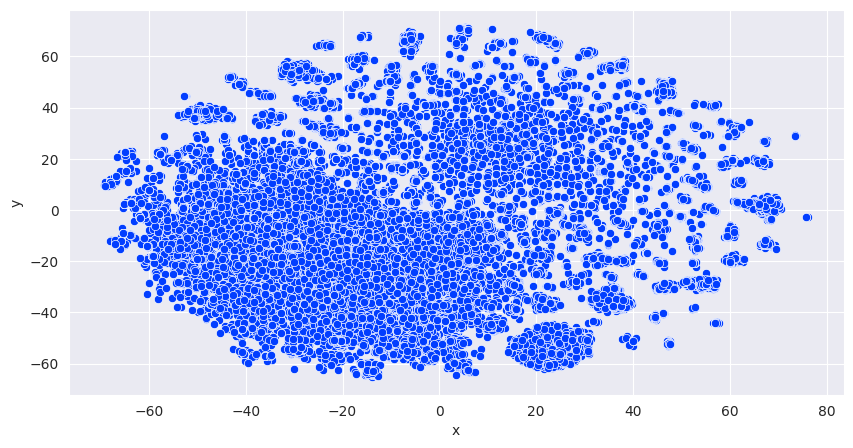

In [ ]:
fig, axs = plt.subplots(1, 1, figsize = (10, 5))
sns.scatterplot(data = tsne_df, x = "x", y = "y")

#### PCA 적용 후 확인

In [ ]:
ex_ratio = []
for i in range(1, 64):
  pca = PCA(n_components = i) # feature 변수 개수가 2개
  pca.fit(user_emb.drop(columns = ["Unnamed: 0", "cust"]))
  ex_ratio.append(sum(pca.explained_variance_ratio_))

ex_diff = []
for idx, ex in enumerate(ex_ratio):
  if idx == 0:
    continue
  diff = ex - ex_ratio[idx - 1]
  ex_diff.append(diff)

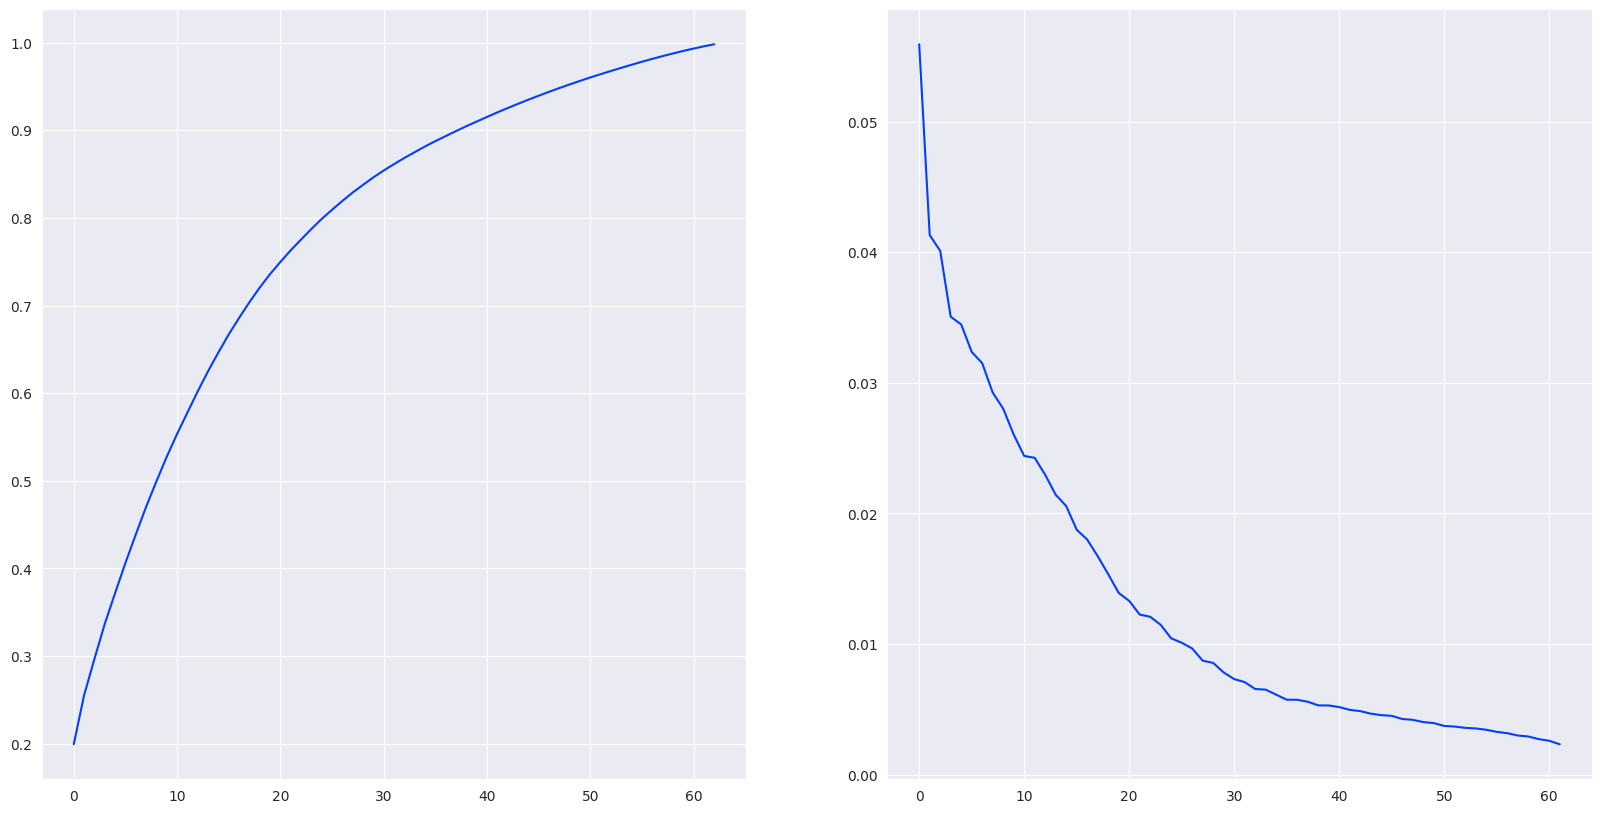

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (20, 10))

axs[0].plot(ex_ratio)
axs[1].plot(ex_diff)

In [ ]:
pca = PCA(n_components = 30)
pca.fit(user_emb.drop(columns = ["Unnamed: 0", "cust"]))

PCA()

In [ ]:
pca_result = pca.transform(user_emb.drop(columns = ["Unnamed: 0", "cust"]))
pca_result

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.496059,0.058319,0.078204,0.015119,0.001610,-0.052340,-0.047835,-0.098024,0.074376,0.046439,...,-0.009200,-0.132029,-0.039302,-0.073307,0.075521,0.143819,-0.025565,-0.010039,0.064967,-0.000573
1,0.518896,0.004636,0.001411,-0.016525,0.034384,-0.021336,-0.018700,-0.041993,0.063639,0.014857,...,-0.126863,-0.080311,-0.174653,-0.171142,0.043759,0.083751,-0.086451,-0.098109,-0.095984,0.028816
2,-0.403038,-0.265075,0.114868,0.029581,0.081520,-0.190956,0.183662,-0.018108,0.039503,-0.402654,...,-0.222664,-0.031745,0.217666,0.054276,0.037974,-0.062159,-0.053147,-0.107436,-0.082368,-0.164995
3,-0.296004,-0.177774,0.229614,0.353553,-0.095474,-0.144061,-0.175815,0.372569,-0.448337,0.107979,...,-0.038673,0.010008,-0.055419,-0.012471,-0.077851,-0.073497,0.046972,0.106111,-0.153942,-0.035680
4,-0.396089,-0.276109,0.224971,-0.556779,-0.317428,0.123780,0.126481,-0.112222,0.036389,-0.044942,...,-0.030823,-0.024896,0.006613,-0.043870,-0.010184,-0.047600,0.041940,-0.069368,-0.059844,-0.003336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29869,0.557285,0.008683,-0.021279,-0.036083,0.068692,-0.022751,-0.007428,-0.018158,-0.005460,-0.020658,...,-0.011893,-0.023196,-0.109601,0.006327,-0.170219,0.064585,-0.071254,0.017151,-0.061199,-0.072647
29870,-0.420651,-0.387981,-0.445628,0.257310,0.190550,0.057558,-0.151739,0.419289,0.241555,-0.098619,...,-0.060463,0.023894,-0.048441,-0.100835,0.006897,0.006902,0.006746,0.012489,-0.007836,0.013567
29871,0.400161,0.035976,0.031252,-0.031314,-0.007913,-0.003893,0.027050,0.020140,-0.008791,-0.013447,...,-0.054399,0.077163,-0.071927,0.160238,0.075608,-0.180668,-0.055771,-0.063644,0.140116,-0.019565
29872,0.333873,-0.054461,-0.069754,-0.052712,0.072990,0.091917,0.054533,0.042190,0.053305,0.033243,...,-0.068426,-0.110978,0.064308,0.083853,0.030047,0.001843,-0.204497,0.001100,-0.070231,0.047339


In [ ]:
user_emb_cudf = cudf.DataFrame(pca_result)
tsne = TSNE(n_components = 2).fit_transform(user_emb_cudf)

/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [05:48:13.551141] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


<Axes: xlabel='x', ylabel='y'>

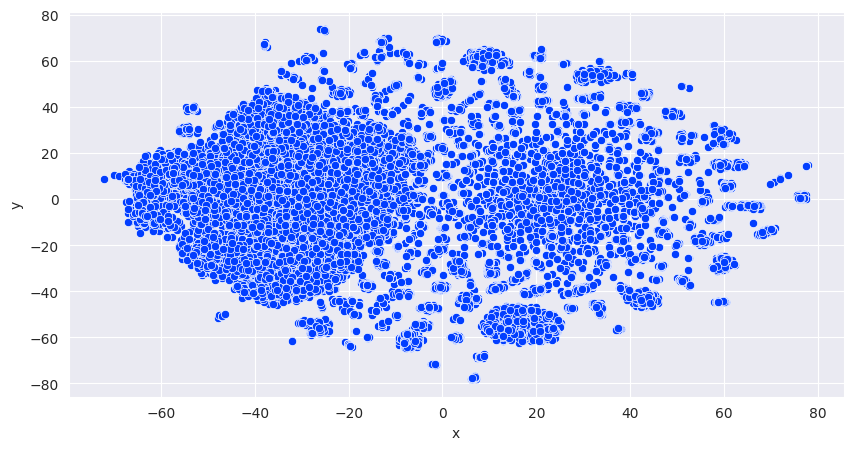

In [ ]:
tsne_df = tsne.to_pandas()
tsne_df.columns = ["x", "y"]

fig, axs = plt.subplots(1, 1, figsize = (10, 5))
sns.scatterplot(data = tsne_df, x = "x", y = "y")

### L2 정규화 t-SNE Plot 결과 확인

In [ ]:
user_emb_cudf = cudf.DataFrame(user_emb)
transformer = Normalizer().fit(user_emb_cudf.drop(columns = ["Unnamed: 0", "cust"]))
tsne = TSNE(n_components = 2).fit_transform(transformer.transform(user_emb_cudf.drop(columns = ["Unnamed: 0", "cust"])))

/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [05:48:28.095921] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


<Axes: xlabel='x', ylabel='y'>

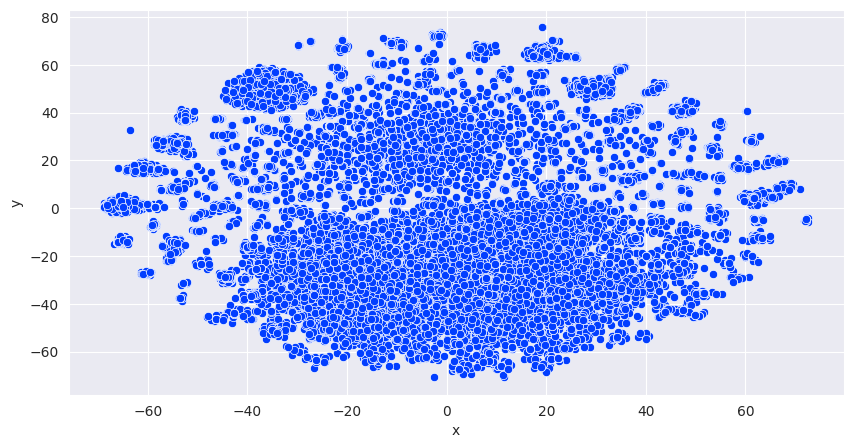

In [ ]:
tsne_df = tsne.to_pandas()
tsne_df.columns = ["x", "y"]

fig, axs = plt.subplots(1, 1, figsize = (10, 5))
sns.scatterplot(data = tsne_df, x = "x", y = "y")

#### PCA 적용 후 확인

In [ ]:
user_emb_t = transformer.transform(user_emb_cudf.drop(columns = ["Unnamed: 0", "cust"]))

In [ ]:
user_emb_t = transformer.transform(user_emb_cudf.drop(columns = ["Unnamed: 0", "cust"]))
user_emb_t = user_emb_t.to_pandas()

ex_ratio = []
for i in range(1, 64):
  pca = PCA(n_components = i) # feature 변수 개수가 2개
  pca.fit(user_emb.drop(columns = ["Unnamed: 0", "cust"]))
  ex_ratio.append(sum(pca.explained_variance_ratio_))

ex_diff = []
for idx, ex in enumerate(ex_ratio):
  if idx == 0:
    continue
  diff = ex - ex_ratio[idx - 1]
  ex_diff.append(diff)

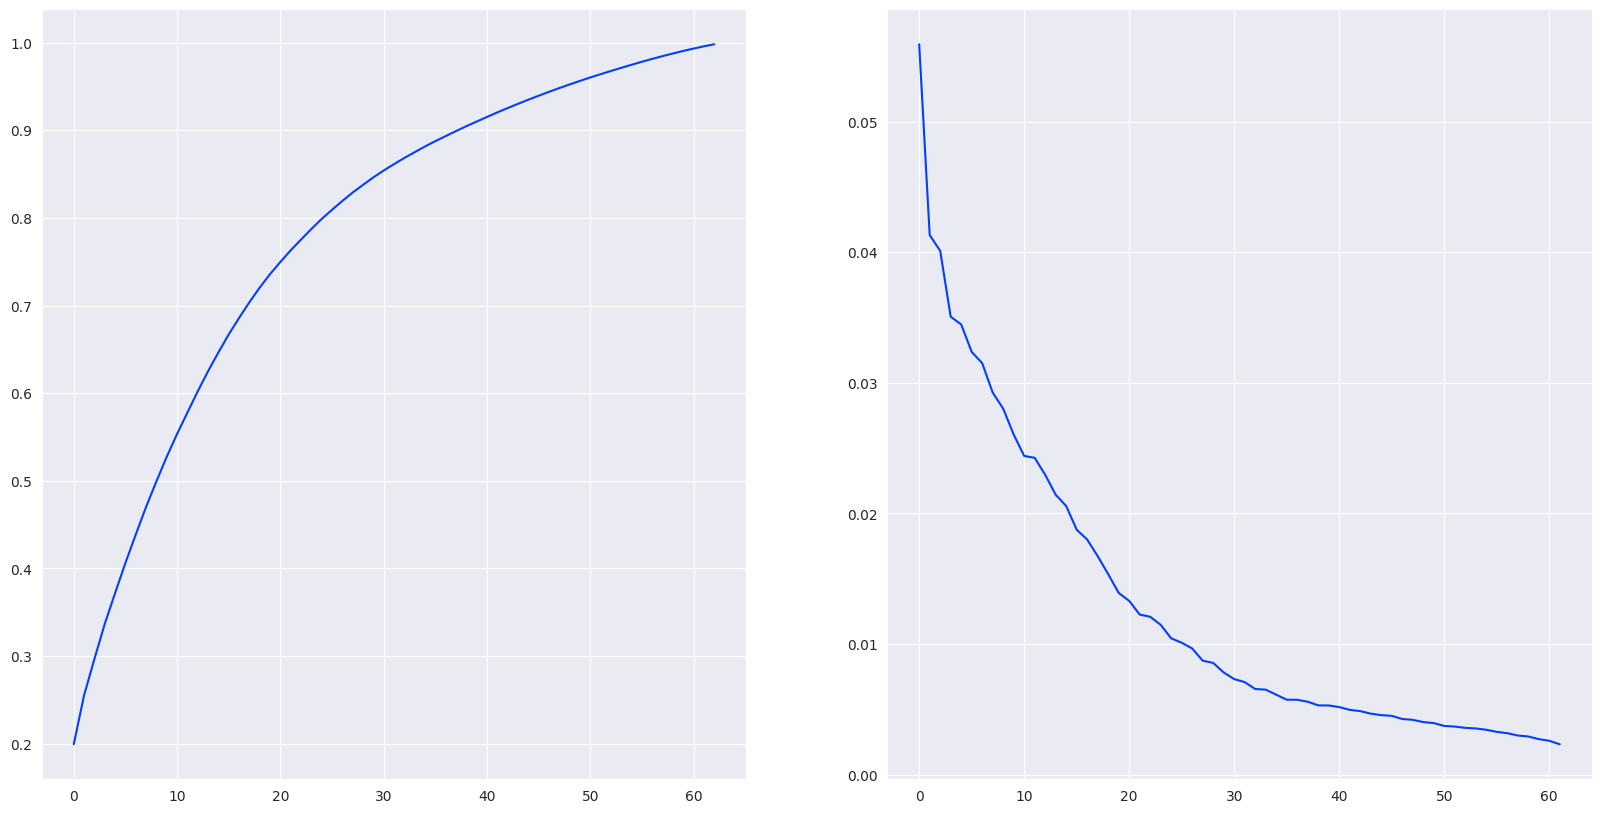

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (20, 10))

axs[0].plot(ex_ratio)
axs[1].plot(ex_diff)

In [ ]:
pca = PCA(n_components = 30)
pca.fit(user_emb_t)

PCA()

In [ ]:
pca_result = pca.transform(user_emb_t)
pca_result

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.496059,0.058319,0.078204,0.015119,0.001610,-0.052340,-0.047835,-0.098024,0.074376,0.046439,...,-0.009200,-0.132029,-0.039302,-0.073307,0.075521,0.143819,-0.025565,-0.010039,0.064967,-0.000573
1,0.518896,0.004636,0.001411,-0.016525,0.034384,-0.021336,-0.018700,-0.041993,0.063639,0.014857,...,-0.126863,-0.080311,-0.174653,-0.171142,0.043759,0.083751,-0.086451,-0.098109,-0.095984,0.028816
2,-0.403038,-0.265075,0.114868,0.029581,0.081520,-0.190956,0.183662,-0.018108,0.039503,-0.402654,...,-0.222664,-0.031745,0.217666,0.054276,0.037974,-0.062159,-0.053147,-0.107436,-0.082368,-0.164995
3,-0.296004,-0.177774,0.229614,0.353553,-0.095474,-0.144061,-0.175815,0.372569,-0.448337,0.107979,...,-0.038673,0.010008,-0.055419,-0.012471,-0.077851,-0.073497,0.046972,0.106111,-0.153942,-0.035680
4,-0.396089,-0.276109,0.224971,-0.556779,-0.317428,0.123780,0.126481,-0.112222,0.036389,-0.044942,...,-0.030823,-0.024896,0.006613,-0.043870,-0.010184,-0.047600,0.041940,-0.069368,-0.059844,-0.003336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29869,0.557285,0.008683,-0.021279,-0.036083,0.068692,-0.022751,-0.007428,-0.018158,-0.005460,-0.020658,...,-0.011893,-0.023196,-0.109601,0.006327,-0.170219,0.064585,-0.071254,0.017151,-0.061199,-0.072647
29870,-0.420651,-0.387981,-0.445628,0.257310,0.190550,0.057558,-0.151739,0.419289,0.241555,-0.098619,...,-0.060463,0.023894,-0.048441,-0.100835,0.006897,0.006902,0.006746,0.012489,-0.007836,0.013567
29871,0.400161,0.035976,0.031252,-0.031314,-0.007913,-0.003893,0.027050,0.020140,-0.008791,-0.013447,...,-0.054399,0.077163,-0.071927,0.160238,0.075608,-0.180668,-0.055771,-0.063644,0.140116,-0.019565
29872,0.333873,-0.054461,-0.069754,-0.052712,0.072990,0.091917,0.054533,0.042190,0.053305,0.033243,...,-0.068426,-0.110978,0.064308,0.083853,0.030047,0.001843,-0.204497,0.001100,-0.070231,0.047339


In [ ]:
user_emb_cudf = cudf.DataFrame(pca_result)
tsne = TSNE(n_components = 2).fit_transform(user_emb_cudf)

/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [05:48:43.599811] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


<Axes: xlabel='x', ylabel='y'>

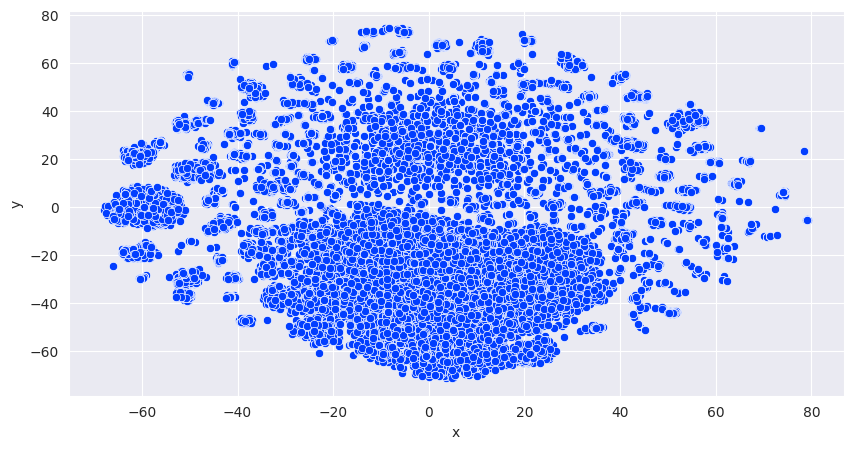

In [ ]:
tsne_df = tsne.to_pandas()
tsne_df.columns = ["x", "y"]

fig, axs = plt.subplots(1, 1, figsize = (10, 5))
sns.scatterplot(data = tsne_df, x = "x", y = "y")

### Standard Scaler t-SNE Plot 결과 확인

In [ ]:
user_emb_cudf = cudf.DataFrame(user_emb)
transformer = StandardScaler().fit(user_emb_cudf.drop(columns = ["Unnamed: 0", "cust"]))
tsne = TSNE(n_components = 2).fit_transform(transformer.transform(user_emb_cudf.drop(columns = ["Unnamed: 0", "cust"])))

[W] [05:48:53.800870] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


<Axes: xlabel='x', ylabel='y'>

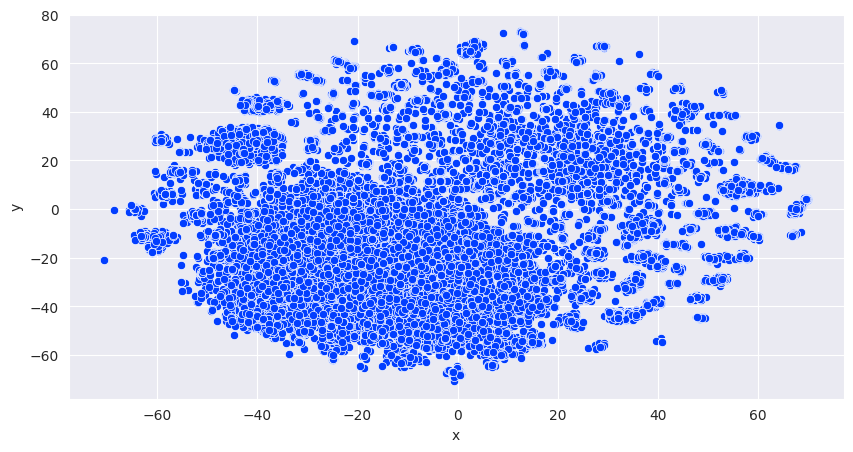

In [ ]:
tsne_df = tsne.to_pandas()
tsne_df.columns = ["x", "y"]

fig, axs = plt.subplots(1, 1, figsize = (10, 5))
sns.scatterplot(data = tsne_df, x = "x", y = "y")

#### PCA 적용 후 확인

In [ ]:
user_emb_t = transformer.transform(user_emb_cudf.drop(columns = ["Unnamed: 0", "cust"]))
user_emb_t = user_emb_t.to_pandas()

ex_ratio = []
for i in range(1, 64):
  pca = PCA(n_components = i) # feature 변수 개수가 2개
  pca.fit(user_emb.drop(columns = ["Unnamed: 0", "cust"]))
  ex_ratio.append(sum(pca.explained_variance_ratio_))

ex_diff = []
for idx, ex in enumerate(ex_ratio):
  if idx == 0:
    continue
  diff = ex - ex_ratio[idx - 1]
  ex_diff.append(diff)

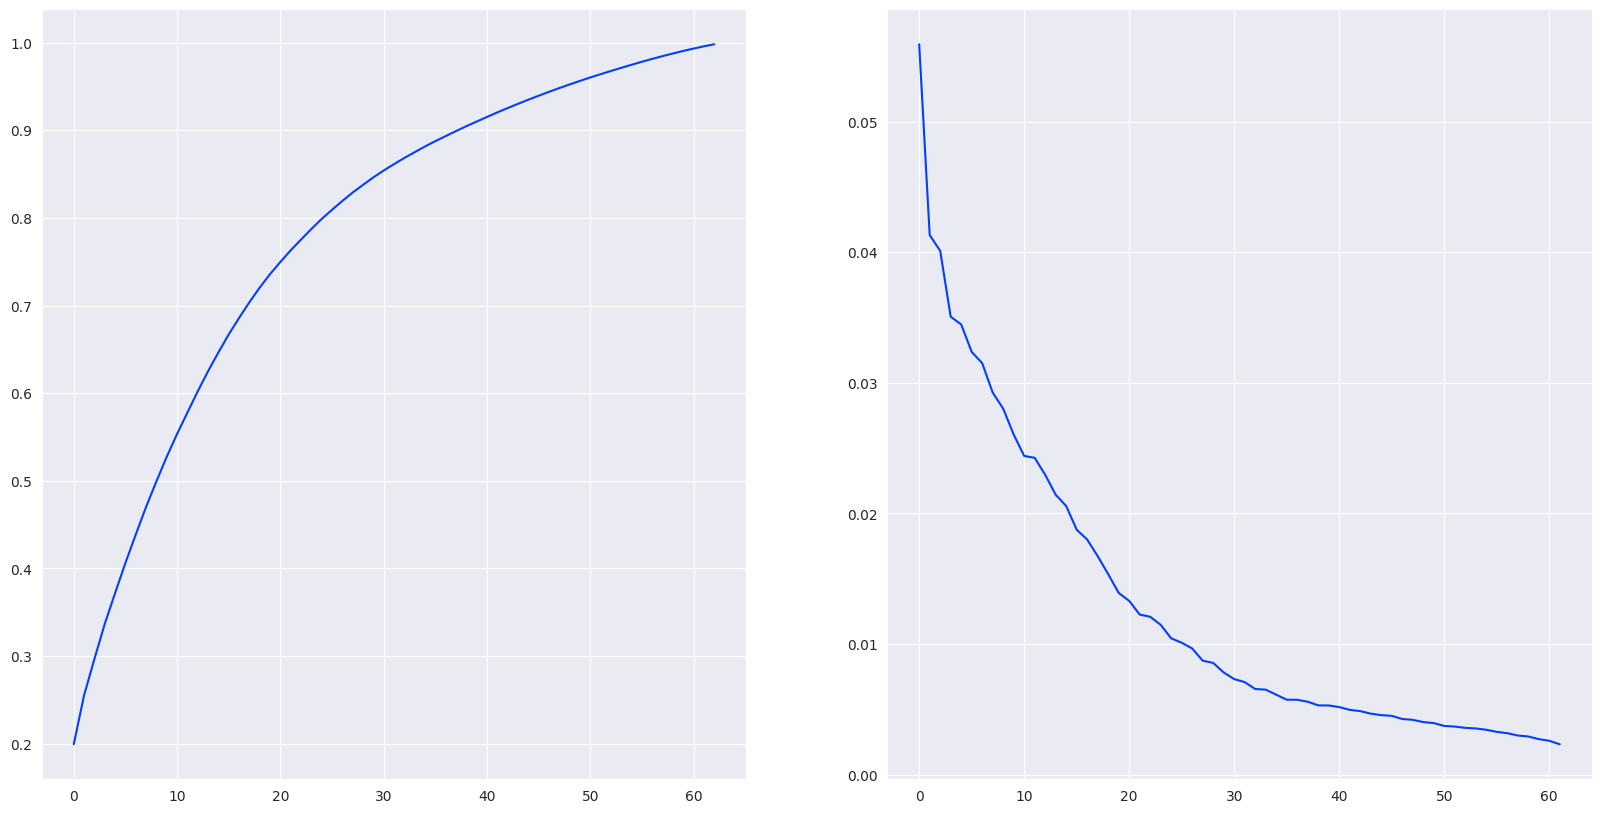

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (20, 10))

axs[0].plot(ex_ratio)
axs[1].plot(ex_diff)

In [ ]:
pca = PCA(n_components = 30)
pca.fit(user_emb_t)

PCA()

In [ ]:
pca_result = pca.transform(user_emb_t)
pca_result

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,2.037404,0.823409,-0.333843,-0.814590,0.258915,-0.855896,1.479092,-0.764375,0.441504,0.819962,...,0.467743,0.710622,-0.397225,-0.671774,-1.442284,1.061830,1.040525,-0.522075,1.173490,0.230641
1,1.974086,-1.028210,1.071052,1.864237,1.467818,-0.485357,-0.851195,0.070745,-0.599360,-0.276218,...,0.201993,-0.115211,-0.014623,-0.576774,-0.251314,1.588501,0.269667,-1.062994,-0.314661,-0.763015
2,-2.189579,-0.685371,-2.575375,0.666047,0.382298,2.711551,-2.333983,-1.650185,-1.140279,-0.794612,...,-0.245298,-1.196856,0.757606,-0.112242,0.564589,0.712216,-0.788674,-0.805490,-0.916850,-0.323269
3,0.415449,0.231512,-2.919102,0.613261,-0.744543,0.852259,-2.982544,0.501120,-0.248881,3.035236,...,-0.892317,0.614529,0.139585,0.303356,-0.828999,0.008107,0.614812,-1.230530,-1.300171,-0.498636
4,-2.679437,-2.467173,-0.282332,-1.963502,3.782708,1.593442,0.534198,-0.238422,1.588757,-1.303421,...,-0.338655,-0.983889,-1.123532,-0.591234,0.557254,0.231642,0.137792,-0.896744,-0.621961,-0.180654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29869,1.541492,-0.590342,0.863542,1.131243,0.963890,-1.085951,-0.499856,-1.153502,-0.713710,-0.171688,...,0.445529,-0.442790,-0.621553,-0.163767,0.262818,0.319558,0.366286,0.754840,-0.728695,0.251329
29870,-1.785962,-3.279607,0.609929,0.920382,-4.266927,-0.149891,-1.058110,-0.227035,-2.320090,2.993040,...,0.284303,-0.315350,-0.402798,-0.082227,-0.198436,0.054907,-0.390783,0.214068,0.243210,-0.275771
29871,1.826376,0.525546,0.024218,-1.691616,-0.199826,1.755036,1.936827,1.184509,-0.572986,-0.856048,...,0.070110,-1.067236,0.850209,-0.750914,1.255371,-2.158165,0.498840,-0.029815,-1.447164,1.187702
29872,0.931330,-1.437401,0.664975,1.174501,-0.126076,0.616486,1.142151,0.766739,-1.405383,0.031790,...,-1.039628,-1.164870,0.230670,1.878982,-1.463777,0.242738,-1.445157,-0.628307,2.645280,-1.044416


In [ ]:
user_emb_cudf = cudf.DataFrame(pca_result)
tsne = TSNE(n_components = 2).fit_transform(user_emb_cudf)

/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [05:49:05.161432] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


<Axes: xlabel='x', ylabel='y'>

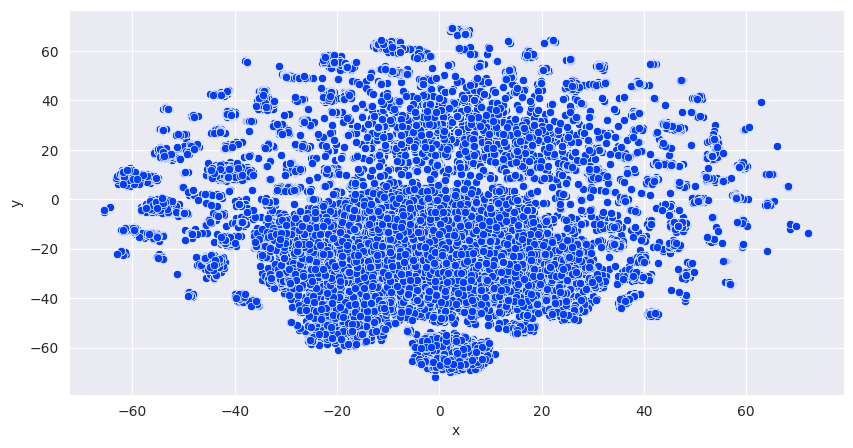

In [ ]:
tsne_df = tsne.to_pandas()
tsne_df.columns = ["x", "y"]

fig, axs = plt.subplots(1, 1, figsize = (10, 5))
sns.scatterplot(data = tsne_df, x = "x", y = "y")

## 가격 정보 X 임베딩

In [ ]:
user_emb_cudf = cudf.DataFrame(user_emb_wo)
tsne = TSNE(n_components = 2).fit_transform(user_emb_cudf.drop(columns = ["Unnamed: 0", "cust"]))

/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [05:49:20.167830] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


In [ ]:
tsne_df = tsne.to_pandas()
tsne_df.columns = ["x", "y"]
tsne_df

,x,y
0,-44.294044,-3.265799
1,-54.549232,-26.961487
2,51.007988,-7.785136
3,4.869799,24.273289
4,58.290478,-1.354119
...,...,...
29869,-26.105652,35.592770
29870,0.007277,-64.070244
29871,-20.254189,14.463444
29872,-16.200424,-30.857561


### t-SNE Plot 결과 확인

<Axes: xlabel='x', ylabel='y'>

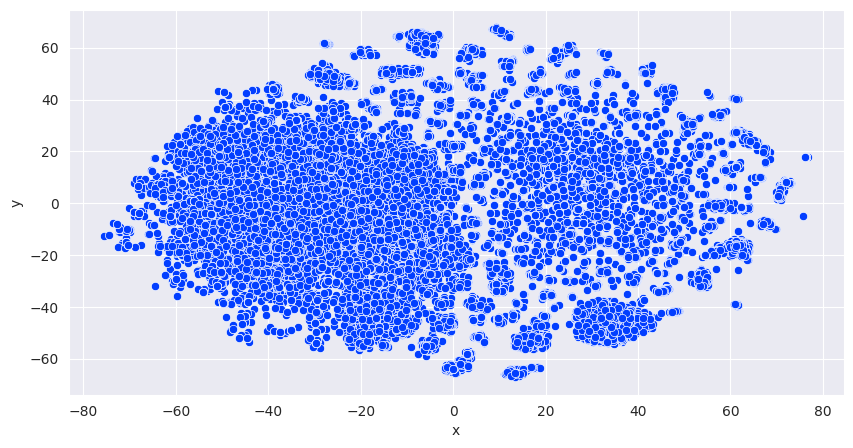

In [ ]:
fig, axs = plt.subplots(1, 1, figsize = (10, 5))
sns.scatterplot(data = tsne_df, x = "x", y = "y")

#### PCA 적용 후 확인

In [ ]:
ex_ratio = []
for i in range(1, 64):
  pca = PCA(n_components = i) # feature 변수 개수가 2개
  pca.fit(user_emb.drop(columns = ["Unnamed: 0", "cust"]))
  ex_ratio.append(sum(pca.explained_variance_ratio_))

ex_diff = []
for idx, ex in enumerate(ex_ratio):
  if idx == 0:
    continue
  diff = ex - ex_ratio[idx - 1]
  ex_diff.append(diff)

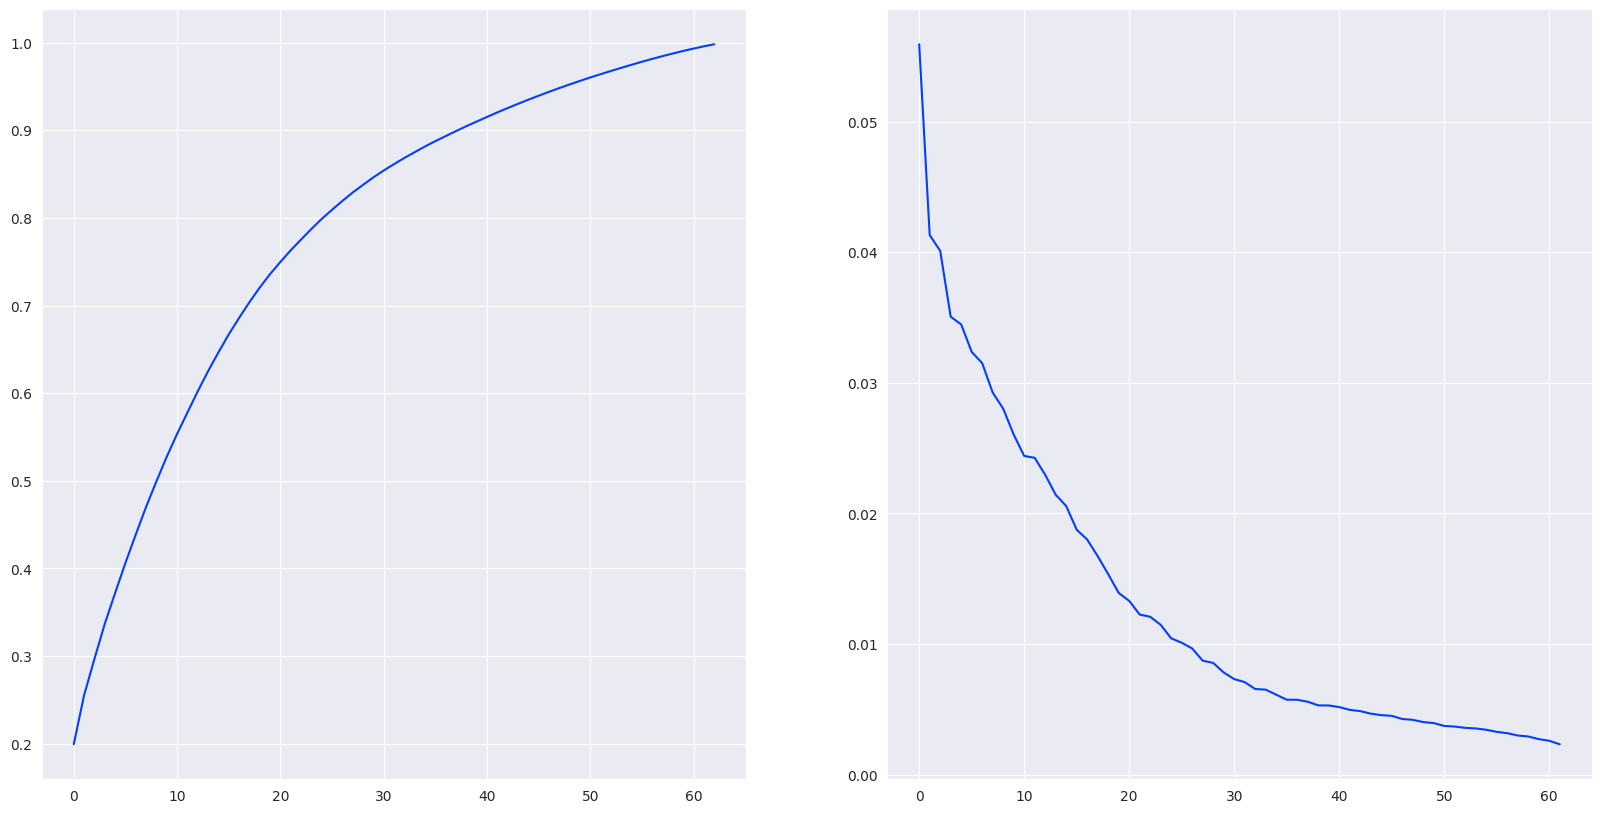

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (20, 10))

axs[0].plot(ex_ratio)
axs[1].plot(ex_diff)

In [ ]:
pca = PCA(n_components = 30)
pca.fit(user_emb.drop(columns = ["Unnamed: 0", "cust"]))

PCA()

In [ ]:
pca_result = pca.transform(user_emb.drop(columns = ["Unnamed: 0", "cust"]))
pca_result

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.496059,0.058319,0.078204,0.015119,0.001610,-0.052340,-0.047835,-0.098024,0.074376,0.046439,...,-0.009200,-0.132029,-0.039302,-0.073307,0.075521,0.143819,-0.025565,-0.010039,0.064967,-0.000573
1,0.518896,0.004636,0.001411,-0.016525,0.034384,-0.021336,-0.018700,-0.041993,0.063639,0.014857,...,-0.126863,-0.080311,-0.174653,-0.171142,0.043759,0.083751,-0.086451,-0.098109,-0.095984,0.028816
2,-0.403038,-0.265075,0.114868,0.029581,0.081520,-0.190956,0.183662,-0.018108,0.039503,-0.402654,...,-0.222664,-0.031745,0.217666,0.054276,0.037974,-0.062159,-0.053147,-0.107436,-0.082368,-0.164995
3,-0.296004,-0.177774,0.229614,0.353553,-0.095474,-0.144061,-0.175815,0.372569,-0.448337,0.107979,...,-0.038673,0.010008,-0.055419,-0.012471,-0.077851,-0.073497,0.046972,0.106111,-0.153942,-0.035680
4,-0.396089,-0.276109,0.224971,-0.556779,-0.317428,0.123780,0.126481,-0.112222,0.036389,-0.044942,...,-0.030823,-0.024896,0.006613,-0.043870,-0.010184,-0.047600,0.041940,-0.069368,-0.059844,-0.003336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29869,0.557285,0.008683,-0.021279,-0.036083,0.068692,-0.022751,-0.007428,-0.018158,-0.005460,-0.020658,...,-0.011893,-0.023196,-0.109601,0.006327,-0.170219,0.064585,-0.071254,0.017151,-0.061199,-0.072647
29870,-0.420651,-0.387981,-0.445628,0.257310,0.190550,0.057558,-0.151739,0.419289,0.241555,-0.098619,...,-0.060463,0.023894,-0.048441,-0.100835,0.006897,0.006902,0.006746,0.012489,-0.007836,0.013567
29871,0.400161,0.035976,0.031252,-0.031314,-0.007913,-0.003893,0.027050,0.020140,-0.008791,-0.013447,...,-0.054399,0.077163,-0.071927,0.160238,0.075608,-0.180668,-0.055771,-0.063644,0.140116,-0.019565
29872,0.333873,-0.054461,-0.069754,-0.052712,0.072990,0.091917,0.054533,0.042190,0.053305,0.033243,...,-0.068426,-0.110978,0.064308,0.083853,0.030047,0.001843,-0.204497,0.001100,-0.070231,0.047339


In [ ]:
user_emb_cudf = cudf.DataFrame(pca_result)
tsne = TSNE(n_components = 2).fit_transform(user_emb_cudf)

/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [05:49:31.163875] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


<Axes: xlabel='x', ylabel='y'>

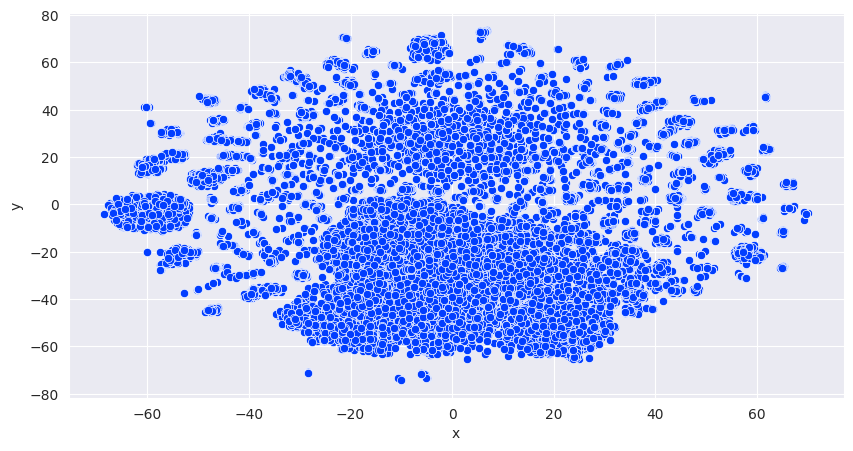

In [ ]:
tsne_df = tsne.to_pandas()
tsne_df.columns = ["x", "y"]

fig, axs = plt.subplots(1, 1, figsize = (10, 5))
sns.scatterplot(data = tsne_df, x = "x", y = "y")

### L2 정규화 t-SNE Plot 결과 확인

In [ ]:
user_emb_cudf = cudf.DataFrame(user_emb)
transformer = Normalizer().fit(user_emb_cudf.drop(columns = ["Unnamed: 0", "cust"]))
tsne = TSNE(n_components = 2).fit_transform(transformer.transform(user_emb_cudf.drop(columns = ["Unnamed: 0", "cust"])))

/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [05:49:40.951556] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


<Axes: xlabel='x', ylabel='y'>

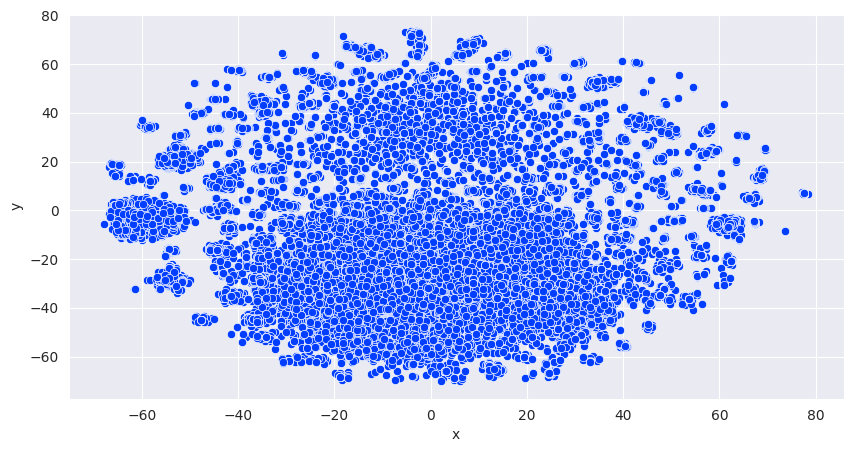

In [ ]:
tsne_df = tsne.to_pandas()
tsne_df.columns = ["x", "y"]

fig, axs = plt.subplots(1, 1, figsize = (10, 5))
sns.scatterplot(data = tsne_df, x = "x", y = "y")

#### PCA 적용 후 확인

In [ ]:
user_emb_t = transformer.transform(user_emb_cudf.drop(columns = ["Unnamed: 0", "cust"]))

In [ ]:
user_emb_t = transformer.transform(user_emb_cudf.drop(columns = ["Unnamed: 0", "cust"]))
user_emb_t = user_emb_t.to_pandas()

ex_ratio = []
for i in range(1, 64):
  pca = PCA(n_components = i) # feature 변수 개수가 2개
  pca.fit(user_emb.drop(columns = ["Unnamed: 0", "cust"]))
  ex_ratio.append(sum(pca.explained_variance_ratio_))

ex_diff = []
for idx, ex in enumerate(ex_ratio):
  if idx == 0:
    continue
  diff = ex - ex_ratio[idx - 1]
  ex_diff.append(diff)

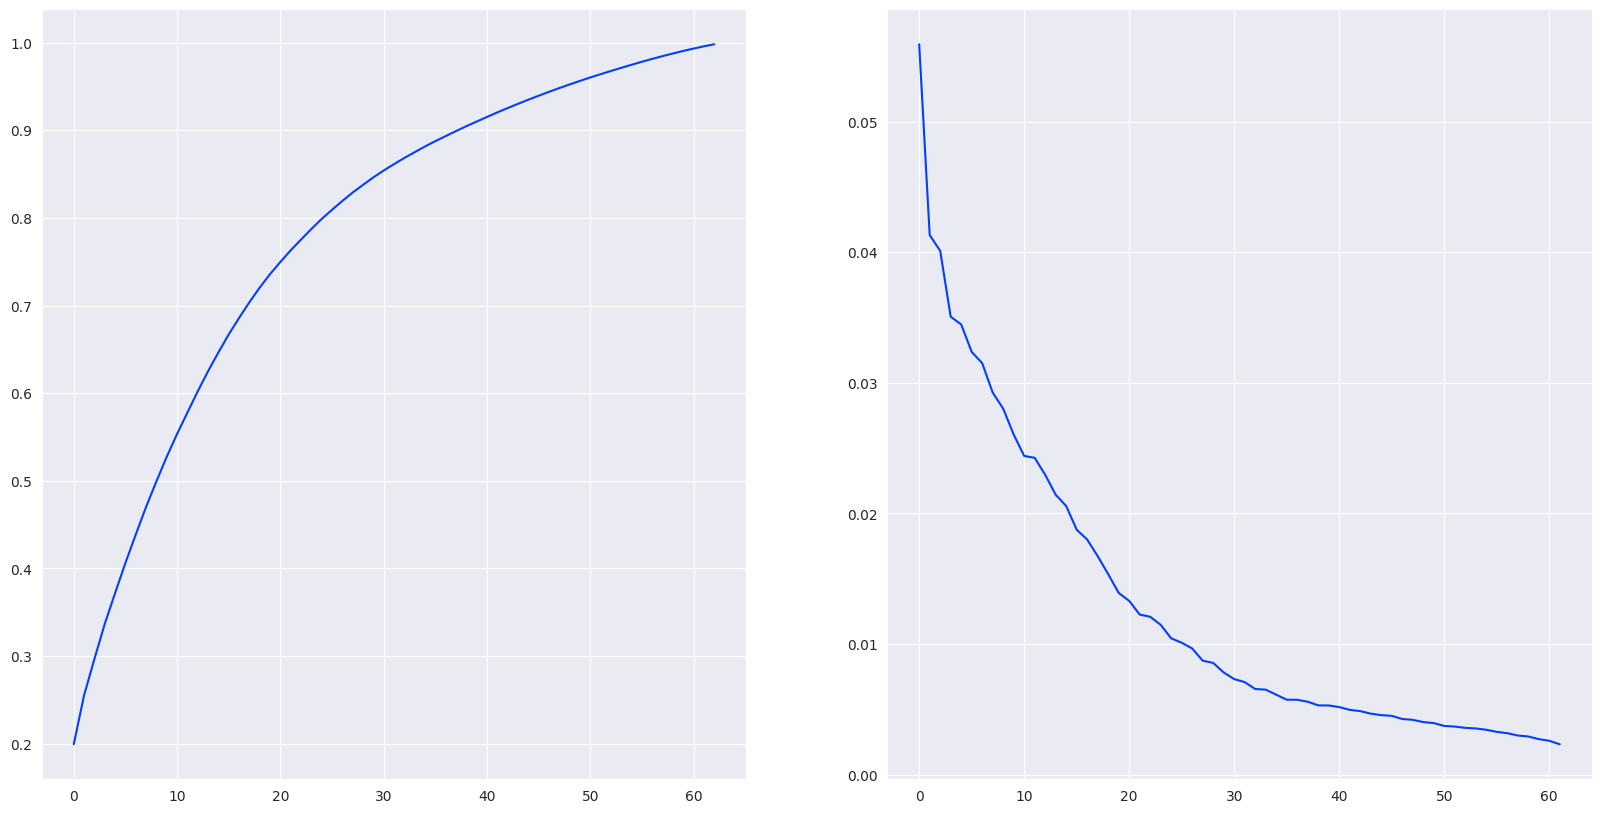

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (20, 10))

axs[0].plot(ex_ratio)
axs[1].plot(ex_diff)

In [ ]:
pca = PCA(n_components = 30)
pca.fit(user_emb_t)

PCA()

In [ ]:
pca_result = pca.transform(user_emb_t)
pca_result

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.496059,0.058319,0.078204,0.015119,0.001610,-0.052340,-0.047835,-0.098024,0.074376,0.046439,...,-0.009200,-0.132029,-0.039302,-0.073307,0.075521,0.143819,-0.025565,-0.010039,0.064967,-0.000573
1,0.518896,0.004636,0.001411,-0.016525,0.034384,-0.021336,-0.018700,-0.041993,0.063639,0.014857,...,-0.126863,-0.080311,-0.174653,-0.171142,0.043759,0.083751,-0.086451,-0.098109,-0.095984,0.028816
2,-0.403038,-0.265075,0.114868,0.029581,0.081520,-0.190956,0.183662,-0.018108,0.039503,-0.402654,...,-0.222664,-0.031745,0.217666,0.054276,0.037974,-0.062159,-0.053147,-0.107436,-0.082368,-0.164995
3,-0.296004,-0.177774,0.229614,0.353553,-0.095474,-0.144061,-0.175815,0.372569,-0.448337,0.107979,...,-0.038673,0.010008,-0.055419,-0.012471,-0.077851,-0.073497,0.046972,0.106111,-0.153942,-0.035680
4,-0.396089,-0.276109,0.224971,-0.556779,-0.317428,0.123780,0.126481,-0.112222,0.036389,-0.044942,...,-0.030823,-0.024896,0.006613,-0.043870,-0.010184,-0.047600,0.041940,-0.069368,-0.059844,-0.003336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29869,0.557285,0.008683,-0.021279,-0.036083,0.068692,-0.022751,-0.007428,-0.018158,-0.005460,-0.020658,...,-0.011893,-0.023196,-0.109601,0.006327,-0.170219,0.064585,-0.071254,0.017151,-0.061199,-0.072647
29870,-0.420651,-0.387981,-0.445628,0.257310,0.190550,0.057558,-0.151739,0.419289,0.241555,-0.098619,...,-0.060463,0.023894,-0.048441,-0.100835,0.006897,0.006902,0.006746,0.012489,-0.007836,0.013567
29871,0.400161,0.035976,0.031252,-0.031314,-0.007913,-0.003893,0.027050,0.020140,-0.008791,-0.013447,...,-0.054399,0.077163,-0.071927,0.160238,0.075608,-0.180668,-0.055771,-0.063644,0.140116,-0.019565
29872,0.333873,-0.054461,-0.069754,-0.052712,0.072990,0.091917,0.054533,0.042190,0.053305,0.033243,...,-0.068426,-0.110978,0.064308,0.083853,0.030047,0.001843,-0.204497,0.001100,-0.070231,0.047339


In [ ]:
user_emb_cudf = cudf.DataFrame(pca_result)
tsne = TSNE(n_components = 2).fit_transform(user_emb_cudf)

/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [05:50:01.594637] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


<Axes: xlabel='x', ylabel='y'>

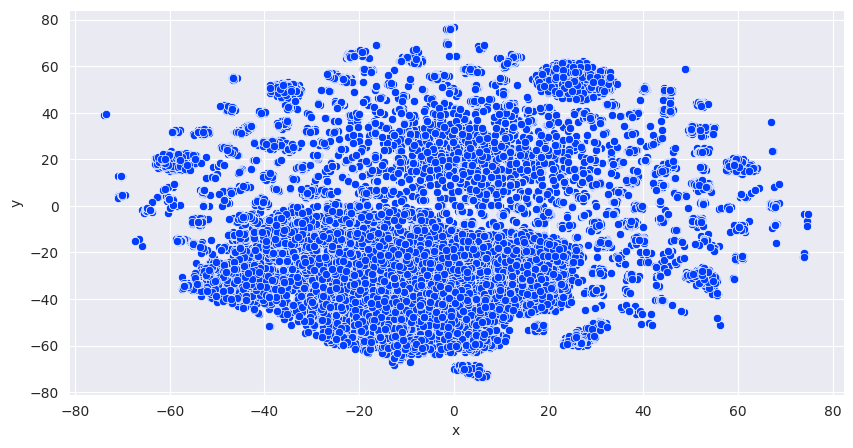

In [ ]:
tsne_df = tsne.to_pandas()
tsne_df.columns = ["x", "y"]

fig, axs = plt.subplots(1, 1, figsize = (10, 5))
sns.scatterplot(data = tsne_df, x = "x", y = "y")

### Standard Scaler t-SNE Plot 결과 확인

In [ ]:
user_emb_cudf = cudf.DataFrame(user_emb)
transformer = StandardScaler().fit(user_emb_cudf.drop(columns = ["Unnamed: 0", "cust"]))
tsne = TSNE(n_components = 2).fit_transform(transformer.transform(user_emb_cudf.drop(columns = ["Unnamed: 0", "cust"])))

/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [05:50:11.463771] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


<Axes: xlabel='x', ylabel='y'>

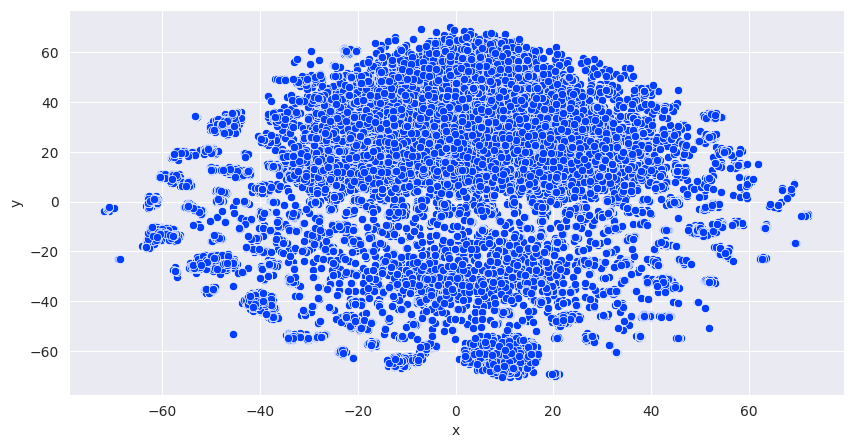

In [ ]:
tsne_df = tsne.to_pandas()
tsne_df.columns = ["x", "y"]

fig, axs = plt.subplots(1, 1, figsize = (10, 5))
sns.scatterplot(data = tsne_df, x = "x", y = "y")

#### PCA 적용 후 확인

In [ ]:
user_emb_t = transformer.transform(user_emb_cudf.drop(columns = ["Unnamed: 0", "cust"]))
user_emb_t = user_emb_t.to_pandas()

ex_ratio = []
for i in range(1, 64):
  pca = PCA(n_components = i) # feature 변수 개수가 2개
  pca.fit(user_emb.drop(columns = ["Unnamed: 0", "cust"]))
  ex_ratio.append(sum(pca.explained_variance_ratio_))

ex_diff = []
for idx, ex in enumerate(ex_ratio):
  if idx == 0:
    continue
  diff = ex - ex_ratio[idx - 1]
  ex_diff.append(diff)

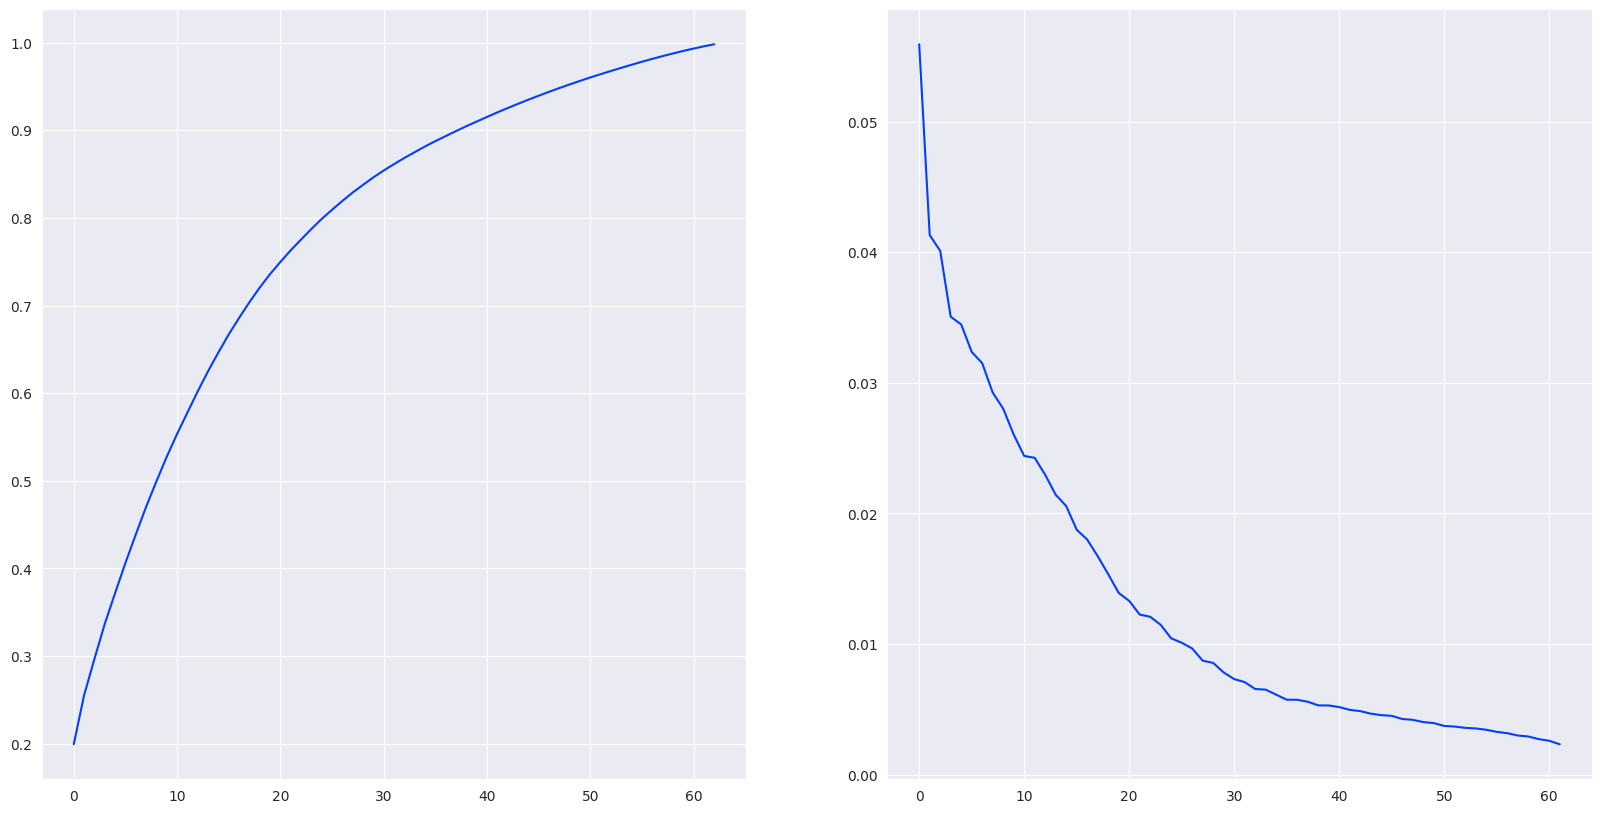

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (20, 10))

axs[0].plot(ex_ratio)
axs[1].plot(ex_diff)

In [ ]:
pca = PCA(n_components = 30)
pca.fit(user_emb_t)

PCA()

In [ ]:
pca_result = pca.transform(user_emb_t)
pca_result

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,2.037404,0.823409,-0.333843,-0.814590,0.258915,-0.855896,1.479092,-0.764375,0.441504,0.819962,...,0.467743,0.710622,-0.397225,-0.671774,-1.442284,1.061830,1.040525,-0.522075,1.173490,0.230641
1,1.974086,-1.028210,1.071052,1.864237,1.467818,-0.485357,-0.851195,0.070745,-0.599360,-0.276218,...,0.201993,-0.115211,-0.014623,-0.576774,-0.251314,1.588501,0.269667,-1.062994,-0.314661,-0.763015
2,-2.189579,-0.685371,-2.575375,0.666047,0.382298,2.711551,-2.333983,-1.650185,-1.140279,-0.794612,...,-0.245298,-1.196856,0.757606,-0.112242,0.564589,0.712216,-0.788674,-0.805490,-0.916850,-0.323269
3,0.415449,0.231512,-2.919102,0.613261,-0.744543,0.852259,-2.982544,0.501120,-0.248881,3.035236,...,-0.892317,0.614529,0.139585,0.303356,-0.828999,0.008107,0.614812,-1.230530,-1.300171,-0.498636
4,-2.679437,-2.467173,-0.282332,-1.963502,3.782708,1.593442,0.534198,-0.238422,1.588757,-1.303421,...,-0.338655,-0.983889,-1.123532,-0.591234,0.557254,0.231642,0.137792,-0.896744,-0.621961,-0.180654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29869,1.541492,-0.590342,0.863542,1.131243,0.963890,-1.085951,-0.499856,-1.153502,-0.713710,-0.171688,...,0.445529,-0.442790,-0.621553,-0.163767,0.262818,0.319558,0.366286,0.754840,-0.728695,0.251329
29870,-1.785962,-3.279607,0.609929,0.920382,-4.266927,-0.149891,-1.058110,-0.227035,-2.320090,2.993040,...,0.284303,-0.315350,-0.402798,-0.082227,-0.198436,0.054907,-0.390783,0.214068,0.243210,-0.275771
29871,1.826376,0.525546,0.024218,-1.691616,-0.199826,1.755036,1.936827,1.184509,-0.572986,-0.856048,...,0.070110,-1.067236,0.850209,-0.750914,1.255371,-2.158165,0.498840,-0.029815,-1.447164,1.187702
29872,0.931330,-1.437401,0.664975,1.174501,-0.126076,0.616486,1.142151,0.766739,-1.405383,0.031790,...,-1.039628,-1.164870,0.230670,1.878982,-1.463777,0.242738,-1.445157,-0.628307,2.645280,-1.044416


In [ ]:
user_emb_cudf = cudf.DataFrame(pca_result)
tsne = TSNE(n_components = 2).fit_transform(user_emb_cudf)

/usr/local/lib/python3.9/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [05:50:24.461045] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


<Axes: xlabel='x', ylabel='y'>

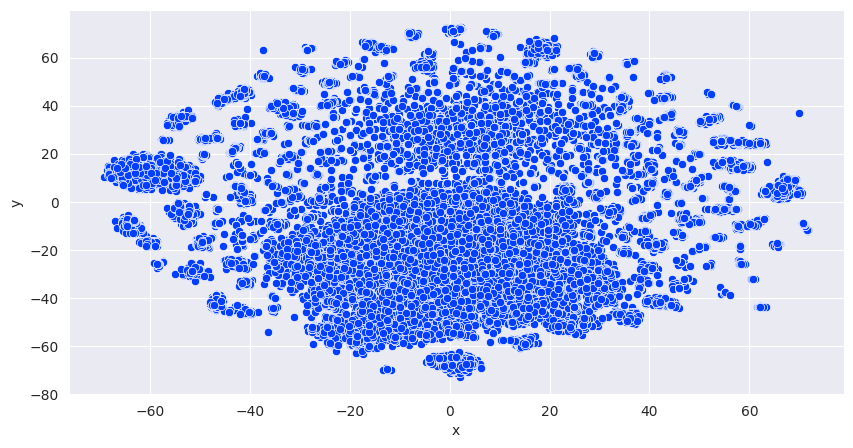

In [ ]:
tsne_df = tsne.to_pandas()
tsne_df.columns = ["x", "y"]

fig, axs = plt.subplots(1, 1, figsize = (10, 5))
sns.scatterplot(data = tsne_df, x = "x", y = "y")